<a href="https://colab.research.google.com/github/dvera14/RPS-1/blob/main/RPS_1_Group_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing

Python executable code that will open up your webcam and take an image when you press 'q'. It will then take the image and split it into 4 sections, one for each hand

Copy the code below into a python file


*   Create virtual environnement
*   Install cv2
*   Run the file
*   press q to take picture and split into 4 images



In [ ]:
import cv2 as cv
import sys
import os

output_folder = 'images'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Open the default camera
cam = cv.VideoCapture(0)

# Get the default frame width and height
frame_width = int(cam.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam.get(cv.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

last_frame = None

print("Press 'q' to take snapshot.")

while True:
    ret, frame = cam.read()

    # Write the frame to the output file
    out.write(frame)

    # Display the captured frame
    cv.imshow('Camera', frame)

    last_frame = frame

    # Press 'q' to exit the loop
    if cv.waitKey(1) == ord('q'):
        break

if last_frame is not None:
    # Save the last frame in the 'images' folder
    last_frame_path = os.path.join(output_folder, 'last_frame.jpg')
    cv.imwrite(last_frame_path, last_frame)
    print(f"Snapshot saved as '{last_frame_path}'")

# Release the capture and writer objects
cam.release()
out.release()
cv.destroyAllWindows()







SPLITTING THE IMAGE

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Replace 'your_image_file.jpg' with the actual path to your uploaded image file
image_path = 'your_image_file.jpg'

try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.title(f'Uploaded Image: {image_path}')
    plt.show()
    print(f'Successfully loaded image from {image_path}. Image size: {img.size}, format: {img.format}')
except FileNotFoundError:
    print(f"Error: The file '{image_path}' was not found. Please ensure the file is uploaded and the path is correct.")
except Exception as e:
    print(f"An error occurred while opening the image: {e}")


In [ ]:
# Read the saved image from the 'images' folder
img = cv.imread(last_frame_path)

if img is None:
    print("Could not read the image.")
    sys.exit()

# Splitting the image into 4 parts
h, w, channels = img.shape

half_width = w // 2
half_height = h // 2

# Splitting into 4 parts. These are numpy 2D arrays
top_left = img[:half_height, :half_width]
top_right = img[:half_height, half_width:]
bottom_left = img[half_height:, :half_width]
bottom_right = img[half_height:, half_width:]

# Save the split images in the 'images' folder
cv.imwrite(os.path.join(output_folder, 'top_left.jpg'), top_left)
cv.imwrite(os.path.join(output_folder, 'top_right.jpg'), top_right)
cv.imwrite(os.path.join(output_folder, 'bottom_left.jpg'), bottom_left)
cv.imwrite(os.path.join(output_folder, 'bottom_right.jpg'), bottom_right)

print("Saved: top_left.jpg, top_right.jpg, bottom_left.jpg, bottom_right.jpg")

In [ ]:
#Image paths

top_left_path = "/content/top_left.jpg"
top_right_path = "/content/top_right.jpg"
bottom_left_path = "/content/bottom_left.jpg"
bottom_right_path = "/content/bottom_right.jpg"

# Training the model

In [ ]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from PIL import Image

# sklearn metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision import models

# torchvision
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from tqdm.auto import tqdm

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Path to your data root
import kagglehub
DATA_DIR = kagglehub.dataset_download('sanikamal/rock-paper-scissors-dataset')
print('Data source import complete.')  # <-- change this to your path

IMG_ROOT = os.path.join(DATA_DIR, "Rock-Paper-Scissors")   # <- this has rock/paper/scissors
print("IMG_ROOT:", IMG_ROOT)
print("Class folders:", os.listdir(IMG_ROOT))
TRAIN_DIR   = os.path.join(IMG_ROOT, "train")
TEST_DIR    = os.path.join(IMG_ROOT, "test")

print("Train dir:", TRAIN_DIR)
print("Test  dir:", TEST_DIR)



Using Colab cache for faster access to the 'rock-paper-scissors-dataset' dataset.
Data source import complete.
IMG_ROOT: /kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors
Class folders: ['validation', 'test', 'train']
Train dir: /kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train
Test  dir: /kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/test


In [ ]:



train_tfms = T.Compose([
    # Random crop & zoom around the hand
    T.RandomResizedCrop(
        size=224,
        scale=(0.6, 1.0),        # zoom in a bit / full image
        ratio=(0.75, 1.33),      # slightly squished or stretched
    ),
    # Simulate different angles / viewpoints
    T.RandomRotation(35),
    T.RandomPerspective(distortion_scale=0.4, p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    # Lighting / color changes
    T.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0.05
    ),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Validation/test: NO crazy augmentation, just deterministic resize
val_tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_tfms = val_tfms


# 3. Base TRAIN dataset (NO transform here)

base_train_ds = ImageFolder(root=TRAIN_DIR, transform=None)
print("Class to index mapping:", base_train_ds.class_to_idx)


# 4. 80/20 train/val split on TRAIN_DIR

indices = list(range(len(base_train_ds)))
labels  = [base_train_ds.samples[i][1] for i in indices]  # class indices

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,           # ~80/20 split
    stratify=labels,
    random_state=42
)

print(f"Total images in TRAIN_DIR: {len(base_train_ds)}")
print(f"Train split: {len(train_idx)}, Val split: {len(val_idx)}")


# 5. Wrapper to apply different transforms

class SubsetWithTransform(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.base_dataset[self.indices[idx]]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

train_ds = SubsetWithTransform(base_train_ds, train_idx, train_tfms)
val_ds   = SubsetWithTransform(base_train_ds, val_idx,   val_tfms)

# TEST set comes directly from TEST_DIR with its own transform
test_ds  = ImageFolder(root=TEST_DIR, transform=test_tfms)


# 6. Dataloaders

batch_size = 32

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=2, persistent_workers=True, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, persistent_workers=True, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, persistent_workers=True, pin_memory=True
)


# 7. Quick sanity check

images, labels = next(iter(train_loader))
print("Train batch shape:", images.shape, "Labels sample:", labels[:8])
print("Num test images:", len(test_ds))

Class to index mapping: {'paper': 0, 'rock': 1, 'scissors': 2}
Total images in TRAIN_DIR: 2520
Train split: 2016, Val split: 504
Train batch shape: torch.Size([32, 3, 224, 224]) Labels sample: tensor([0, 2, 2, 2, 2, 1, 1, 0])
Num test images: 372


In [ ]:

from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# First freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last residual block + final FC layer
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Only optimize the unfrozen params (layer4 + fc)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 15 # adjust as needed

history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
best_val_loss = float("inf")
best_model_path = "rps_best_model.pth"

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    # ---- Train ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)              # [batch, 3]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---- Validate ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Save best model
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), best_model_path)
        best_val_loss = val_loss
        print(f"New best model saved (val_loss = {best_val_loss:.4f})")

    print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.4f}")



Epoch 1/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0215)
Train Loss: 0.2292  Train Acc: 0.9246
Val   Loss: 0.0215  Val   Acc: 0.9960

Epoch 2/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0193)
Train Loss: 0.0414  Train Acc: 0.9876
Val   Loss: 0.0193  Val   Acc: 0.9921

Epoch 3/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0088)
Train Loss: 0.0268  Train Acc: 0.9931
Val   Loss: 0.0088  Val   Acc: 0.9980

Epoch 4/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0028)
Train Loss: 0.0311  Train Acc: 0.9901
Val   Loss: 0.0028  Val   Acc: 1.0000

Epoch 5/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0018)
Train Loss: 0.0214  Train Acc: 0.9926
Val   Loss: 0.0018  Val   Acc: 1.0000

Epoch 6/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0162  Train Acc: 0.9955
Val   Loss: 0.0025  Val   Acc: 1.0000

Epoch 7/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0216  Train Acc: 0.9926
Val   Loss: 0.0182  Val   Acc: 0.9921

Epoch 8/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0015)
Train Loss: 0.0181  Train Acc: 0.9945
Val   Loss: 0.0015  Val   Acc: 1.0000

Epoch 9/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0011)
Train Loss: 0.0171  Train Acc: 0.9950
Val   Loss: 0.0011  Val   Acc: 1.0000

Epoch 10/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0007)
Train Loss: 0.0103  Train Acc: 0.9965
Val   Loss: 0.0007  Val   Acc: 1.0000

Epoch 11/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0007)
Train Loss: 0.0153  Train Acc: 0.9931
Val   Loss: 0.0007  Val   Acc: 1.0000

Epoch 12/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0052  Train Acc: 0.9995
Val   Loss: 0.0012  Val   Acc: 1.0000

Epoch 13/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0005)
Train Loss: 0.0075  Train Acc: 0.9980
Val   Loss: 0.0005  Val   Acc: 1.0000

Epoch 14/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0041  Train Acc: 0.9995
Val   Loss: 0.0006  Val   Acc: 1.0000

Epoch 15/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0081  Train Acc: 0.9970
Val   Loss: 0.0007  Val   Acc: 1.0000


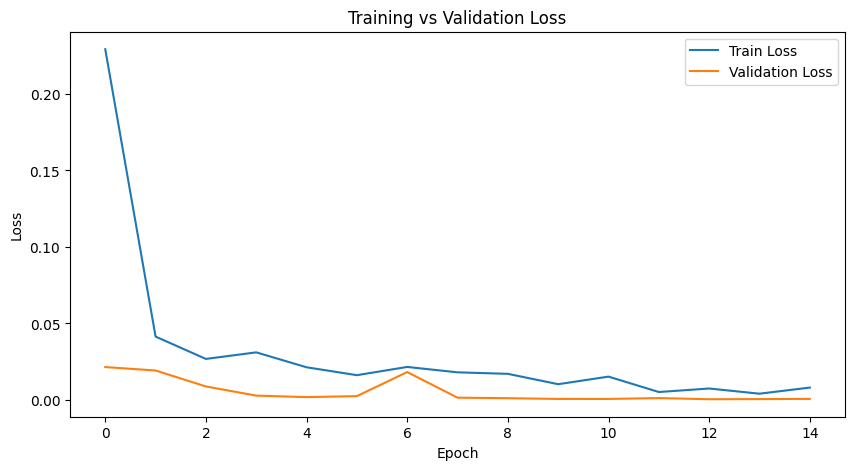

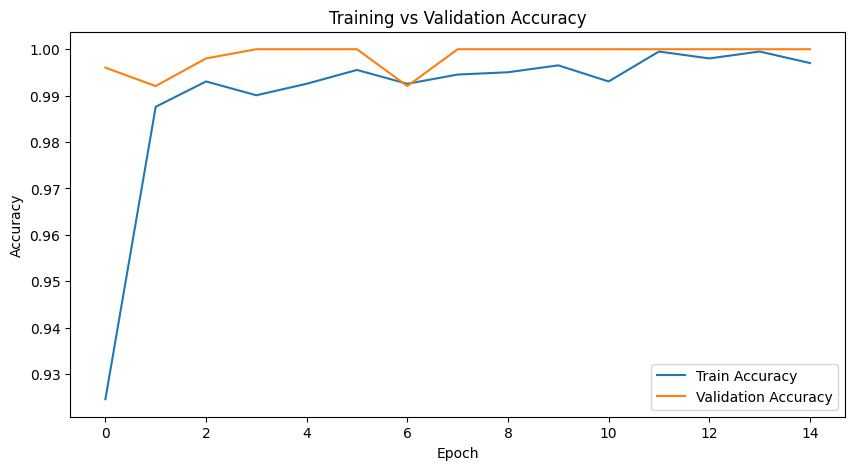

In [ ]:
# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history["acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Validation performance (macro):
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

Classification report:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       168
        rock       1.00      1.00      1.00       168
    scissors       1.00      1.00      1.00       168

    accuracy                           1.00       504
   macro avg       1.00      1.00      1.00       504
weighted avg       1.00      1.00      1.00       504



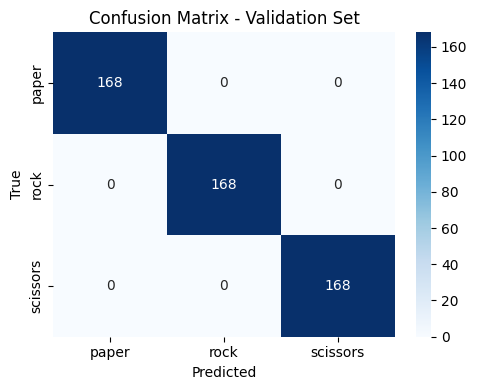


Macro AUC (OVR): 1.0000


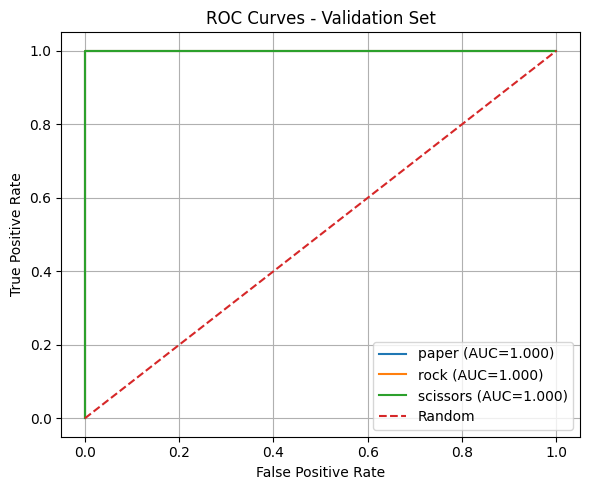

In [ ]:

# ---------- Load best model ----------
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_labels = []
all_preds  = []
all_probs  = []   # <-- softmax scores

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs   = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds  = np.concatenate(all_preds)
all_probs  = np.concatenate(all_probs)

# ---------- Metrics ----------
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="macro")
rec  = recall_score(all_labels, all_preds, average="macro")
f1   = f1_score(all_labels, all_preds, average="macro")

print("Validation performance (macro):")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Correct class names
idx_to_class = {v: k for k, v in base_train_ds.class_to_idx.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

# ---------- ROC & AUC ----------
n_classes = all_probs.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(6, 5))

for i in range(n_classes):
    y_true = (all_labels == i).astype(int)
    y_score = all_probs[:, i]

    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = roc_auc_score(y_true, y_score)

    plt.plot(fpr[i], tpr[i], label=f"{idx_to_class[i]} (AUC={roc_auc[i]:.3f})")


macro_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr", average="macro")
print(f"\nMacro AUC (OVR): {macro_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()






# Loading the model and predicting the classes

idx_to_class: {0: 'paper', 1: 'rock', 2: 'scissors'}

Predicted class: rock (confidence = 0.910)
Class probabilities:
  paper    : 0.003
  rock     : 0.910
  scissors : 0.086

Predicted class: rock (confidence = 0.886)
Class probabilities:
  paper    : 0.024
  rock     : 0.886
  scissors : 0.090

Predicted class: paper (confidence = 0.995)
Class probabilities:
  paper    : 0.995
  rock     : 0.000
  scissors : 0.004

Predicted class: scissors (confidence = 0.979)
Class probabilities:
  paper    : 0.012
  rock     : 0.009
  scissors : 0.979


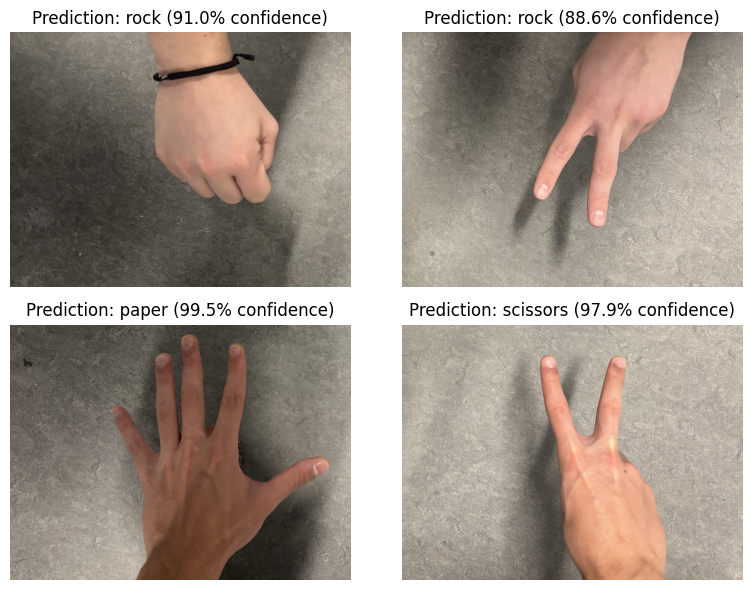

In [ ]:
import matplotlib.pyplot as plt



# Class mapping from the *training* dataset
idx_to_class = {v: k for k, v in base_train_ds.class_to_idx.items()}
print("idx_to_class:", idx_to_class)

# Use the same transforms as validation
infer_tfms = val_tfms

 # 3. Load best weights (val-loss best) and eval mode
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

def predict_hand_image(image_path, show_probs=True):
    """
    Load an image from `image_path`, run it through the trained model,
    and return (PIL image, predicted class name, confidence, probs array).
    """
    # 1. Load image
    img = Image.open(image_path).convert("RGB")

    # 2. Apply transforms and add batch dimension
    x = infer_tfms(img).unsqueeze(0).to(device)   # [1, 3, 224, 224]



    # 4. Forward pass
    with torch.no_grad():
        logits = model(x)                         # [1, 3]
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    # 5. Get prediction + confidence
    pred_idx = int(np.argmax(probs))
    pred_class = idx_to_class[pred_idx]
    confidence = probs[pred_idx]

    if show_probs:
        print(f"\nPredicted class: {pred_class} (confidence = {confidence:.3f})")
        print("Class probabilities:")
        for i, class_name in idx_to_class.items():
            print(f"  {class_name:9s}: {probs[i]:.3f}")

    return img, pred_class, confidence, probs

# ---- Call the function and plot ----
img, pred_class, conf, probs = predict_hand_image(top_left_path, show_probs=True)
img2, pred_class2, conf2, probs2 = predict_hand_image(top_right_path, show_probs=True)
img3, pred_class3, conf3, probs3 = predict_hand_image(bottom_left_path, show_probs=True)
img4, pred_class4, conf4, probs4 = predict_hand_image(bottom_right_path, show_probs=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Top left Hand
axes[0, 0].imshow(img)
axes[0, 0].axis("off")
axes[0, 0].set_title(f"Prediction: {pred_class} ({conf:.1%} confidence)")

# Top right Hand
axes[0, 1].imshow(img2)
axes[0, 1].axis("off")
axes[0, 1].set_title(f"Prediction: {pred_class2} ({conf2:.1%} confidence)")

# Bottom left_hand
axes[1, 0].imshow(img3)
axes[1, 0].axis("off")
axes[1, 0].set_title(f"Prediction: {pred_class3} ({conf3:.1%} confidence)")


# Bottom right Hand
axes[1, 1].imshow(img4)
axes[1, 1].axis("off")
axes[1, 1].set_title(f"Prediction: {pred_class4} ({conf4:.1%} confidence)")

plt.tight_layout()
plt.show()

# Decision


In [ ]:
pred_classes = [pred_class, pred_class2, pred_class3, pred_class4]
print(pred_classes)

def get_winner(p1, p2):
  if p1 == p2:
    return 0  # Tie
  elif (p1 == "rock" and p2 == "scissors") or \
       (p1 == "scissors" and p2 == "paper") or \
       (p1 == "paper" and p2 == "rock"):
    return 1  # p1 wins
  else:
    return -1 # p2 wins

def decision(predictions):
  # Assuming predictions[0] is player 1's left hand and predictions[1] is player 1's right hand
  # Assuming predictions[2] is player 2's left hand and predictions[3] is player 2's right hand

  # Evaluate player 1's left hand against player 2's hands
  score_p1_left = get_winner(predictions[2], predictions[0]) + get_winner(predictions[2], predictions[1])

  # Evaluate player 1's right hand against player 2's hands
  score_p1_right = get_winner(predictions[3], predictions[0]) + get_winner(predictions[3], predictions[1])

  if score_p1_left > score_p1_right:
    return "keep left hand"
  elif score_p1_right > score_p1_left:
    return "keep right hand"
  else:
    return "It's a tie or equally optimal choice"

print(decision(pred_classes))

['rock', 'rock', 'paper', 'scissors']
keep left hand
